In [17]:
import importlib.util
import pathlib

import lightning
import torch

import sainomore

In [34]:
project = pathlib.Path(pathlib.Path.cwd(), "long_lookup")

main_file = project / "main.py"
checkpoint = "version_2"

In [35]:
spec = importlib.util.spec_from_file_location(main_file.stem, main_file)
if spec is not None and spec.loader is not None:
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    lightning_module: lightning.LightningModule = module.build_model()
    model: sainomore.SAINoMoreModule = lightning_module.model
else:
    raise TypeError("Model cannot be compiled")

In [37]:
for folder in project.iterdir():
    path = project / folder
    if not (path.is_dir() and (path / checkpoint).is_dir()):
        continue
    chckpt_path = path / checkpoint / "checkpoints"
    load = chckpt_path / next(chckpt_path.iterdir())
    saved_ = torch.load(load)
    lightning_module.load_state_dict(saved_["state_dict"])
    print("[loaded]")

[loaded]


In [50]:
x, y = sainomore.data.long_lookup(1, model.config.context_length, 5)
x, y

(tensor([[1, 3, 0, 0, 2, 4, 0, 0, 2, 2, 3, 3, 0, 3, 3, 1, 3, 3, 1, 1, 3, 3, 4, 2,
          3]]),
 tensor([[3, 0, 0, 2, 4, 0, 0, 2, 2, 3, 3, 0, 3, 3, 1, 3, 3, 1, 1, 3, 3, 4, 2, 3,
          1]]))

In [51]:
torch.argmax(model(x)[0, :, :], dim=0)

tensor([2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        1])

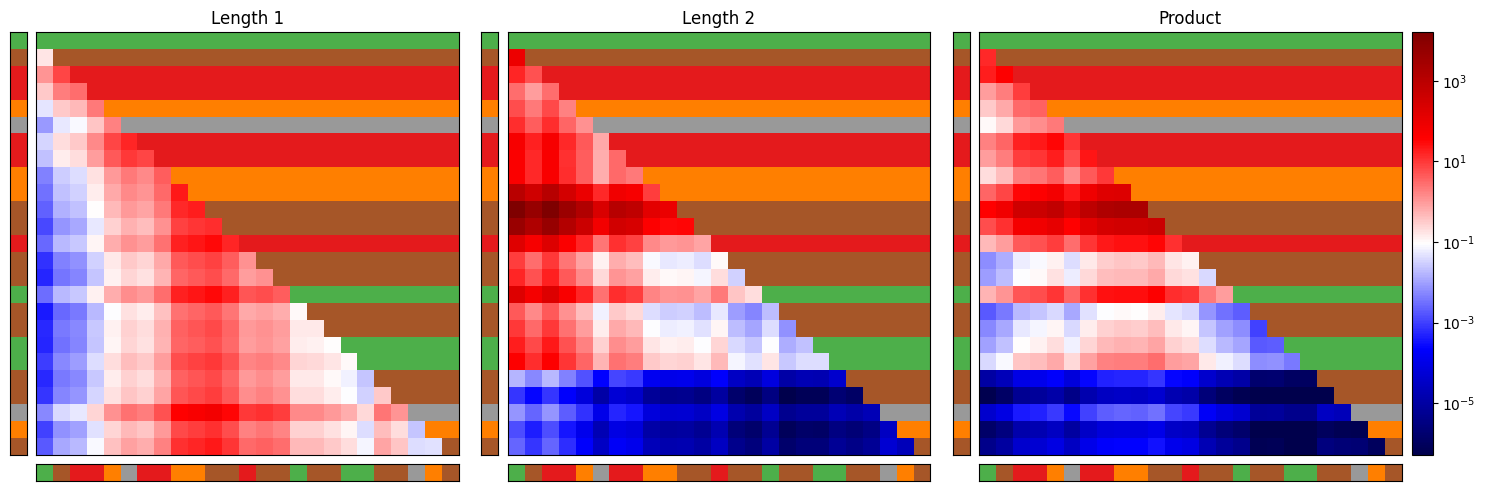

In [53]:
index = torch.norm(
    model.get_parameter("layers.0.W_O"),
    dim=3,
)[:, 0, 0].argmax()

matrix = sainomore.tools.get_liss_attention_matrix(model, x)
fig, ax = sainomore.tools.plot_liss_attention_matrix(
    matrix[0, ..., index],
    x.numpy()[0],
    causal_mask=True,
    show_product=True,
    figsize=(15, 10),
    log_colormap=True,
)

In [24]:
# %matplotlib widget
# matrix = sainomore.tools.get_liss_attention_matrix(model, x, dims=3)
# fig, ax = sainomore.tools.plot_liss_attention_matrix(
#     matrix[0, ..., index],
#     x.numpy()[0],
#     figsize=(15, 10),
#     log_colormap=False,
# )